# OpendTect points to seismic subimages


## Read OdT data

First we want to read the OdT pointset files.

In [2]:
with open("/home/matt/Downloads/salt.pck", 'r') as f:
    data = f.read()
    
print(data[:300])

dTect V6.4
PickSet Group
ons. 18 sep 2019, 14:00:16
!
Z-Unit: Seconds
!
616522.7177599	6081983.02383028	1.78091901	24.99897766	1.57079637	0.02792416
616612.8505724	6081985.54336153	1.74458008	24.99897766	1.57079637	0.02792416
616951.00779896	6081994.99355684	1.67791951	24.99897766	1.57079637	0.02792


This seems to be:

- UTMx, UTMy, TWTT, something, something, something

In [56]:
import numpy as np

def read_odt_pts(fname):
    data = np.loadtxt(fname, skiprows=6, comments='!', usecols=[0,1,2])
    return data

In [57]:
# Example
fname = "/home/matt/Downloads/salt.pck"
d = read_odt_pts(fname)
d

array([[6.16522718e+05, 6.08198302e+06, 1.78091901e+00],
       [6.16612851e+05, 6.08198554e+06, 1.74458008e+00],
       [6.16951008e+05, 6.08199499e+06, 1.67791951e+00],
       [6.16984838e+05, 6.08199594e+06, 1.63165966e+00],
       [6.17176587e+05, 6.08200130e+06, 1.60028747e+00],
       [6.17503880e+05, 6.08201045e+06, 1.59560456e+00],
       [6.17955709e+05, 6.08202307e+06, 1.62453077e+00],
       [6.18294879e+05, 6.08203255e+06, 1.65339516e+00],
       [6.18622987e+05, 6.08204172e+06, 1.68029861e+00],
       [6.19132597e+05, 6.08205596e+06, 1.70935266e+00],
       [6.19291260e+05, 6.08206040e+06, 1.68776755e+00],
       [6.19665473e+05, 6.08207086e+06, 1.67030214e+00],
       [6.19778931e+05, 6.08207403e+06, 1.66545579e+00],
       [6.16691731e+05, 6.08198775e+06, 1.78107929e+00]])

## Read Petrel data

In [92]:
from io import StringIO

def read_petrel_points(filename):
    """
    Read a Petrel points file. Return an array.
    TODO:
        Do something with Comments and Fields.
    """
    with open(filename) as f:

        comments = []
        fields = []
        in_header = False

        while True:
            line = f.readline().strip()

            if line.startswith('#'):
                comments.append(line.strip('# '))
            elif line.startswith('VERSION'):
                # version = line.split()[-1]
                pass
            elif line.startswith('BEGIN'):
                in_header = True
            elif line.startswith('END'):
                in_header = False
                break
            elif in_header:
                fields.append(line.strip())
            else:
                break

        d = f.read()
        s = StringIO(d)

        return np.loadtxt(s)


In [93]:
d = read_petrel_points('/home/matt/Downloads/fault')

In [89]:
d

array([[ 6.08930490e+05,  6.07364300e+06, -1.55876000e+03],
       [ 6.08930490e+05,  6.07364300e+06, -1.57642000e+03],
       [ 6.08953350e+05,  6.07364364e+06, -1.59858000e+03],
       [ 6.08976210e+05,  6.07364428e+06, -1.61895000e+03],
       [ 6.08986970e+05,  6.07364458e+06, -1.64194000e+03],
       [ 6.09009830e+05,  6.07364522e+06, -1.65866000e+03],
       [ 6.09044790e+05,  6.07364619e+06, -1.67726000e+03],
       [ 6.09067650e+05,  6.07364683e+06, -1.69931000e+03],
       [ 6.09067650e+05,  6.07364683e+06, -1.71885000e+03],
       [ 6.09101270e+05,  6.07364777e+06, -1.74529000e+03],
       [ 6.09124130e+05,  6.07364841e+06, -1.77277000e+03],
       [ 6.09146980e+05,  6.07364905e+06, -1.80192000e+03],
       [ 6.09169840e+05,  6.07364969e+06, -1.82846000e+03],
       [ 6.09180600e+05,  6.07364999e+06, -1.84790000e+03],
       [ 6.10272480e+05,  6.07368050e+06, -1.53849000e+03],
       [ 6.10341060e+05,  6.07368242e+06, -1.55970000e+03],
       [ 6.10341060e+05,  6.07368242e+06

## Transform coordinates from UTM to inline/crossline

In [94]:
f3_corners_xy = np.array([
    [605835.5, 6073556.5],
    [629576.25, 6074220.0],
    [629122.5, 6090463.2]
   ])

f3_corners_ix = np.array([[0,  0],
                          [0, 950],
                          [650, 950]
                         ])

import bruges as bg

transform = bg.transform.CoordTransform(f3_corners_ix, f3_corners_xy)

In [95]:
# Example:
transform.reverse(d[0, :2])

array([  0, 124])

In [96]:
# Put it all together
def pts_to_ixt(fname, dt=0.004):
    data = read_odt_pts(fname)
    transform = bg.transform.CoordTransform(f3_corners_ix, f3_corners_xy)
    ix = [transform.reverse(r) for r in data[:, :2]]
    t = (data[:, 2][:, None] / dt).astype(int)
    ixt = np.hstack([ix, t])
    return ixt

ixt = pts_to_ixt("/home/matt/Downloads/salt.pck")

In [97]:
ixt.shape

(14, 3)

In [98]:
ixt

array([[325, 437, 445],
       [325, 440, 436],
       [325, 454, 419],
       [325, 455, 407],
       [325, 463, 400],
       [325, 476, 398],
       [325, 494, 406],
       [325, 508, 413],
       [325, 521, 420],
       [325, 541, 427],
       [325, 548, 421],
       [325, 562, 417],
       [325, 567, 416],
       [325, 443, 445]])

## Extract data

In [99]:
# This is 278MB in memory
f3 = np.random.randint(0, 256, size=(650, 950, 450), dtype=np.uint8)

In [100]:
samples = []
for (i, x, t) in ixt:
    sample = f3[i-3:i+3, x-3:x+3, t]
    samples.append(sample)

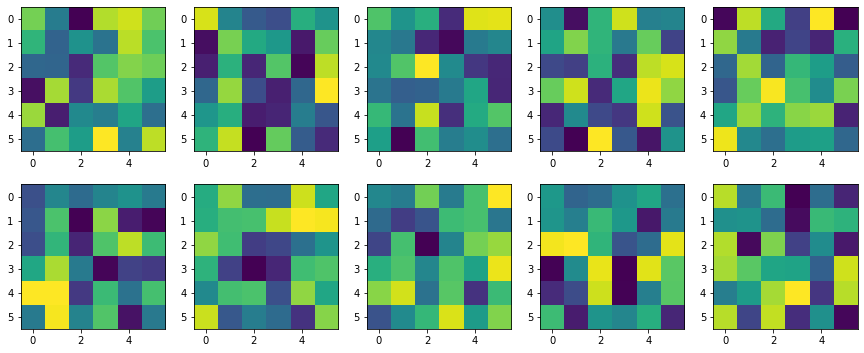

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, sample in zip(axs.ravel(), samples[:10]):
    ax.imshow(sample)

## Unsupervised dimensionality reduction on seismic data

I'm going to use a smaller version of F3.

In [37]:
import numpy as np

f3 = np.load("/home/matt/Dropbox/dev/geocomp-19/data/F3_volume_3x3_16bit.npy")

In [38]:
# Normalize to 1
f3 = f3 / np.amax(np.abs(f3))

In [39]:
f3.shape

(194, 299, 451)

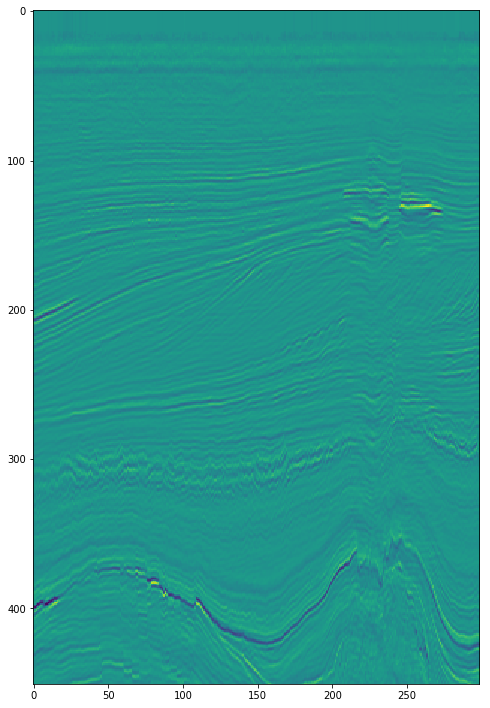

In [64]:
plt.figure(figsize=(8, 16))
plt.imshow(f3[10, :, :].T)

In [66]:
f3_ = f3[10:31, 10:31, 15:450]
f3_.shape

(21, 21, 435)

'Tile' (in 3d) the volume. From https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes

In [69]:
import numpy as np

def cubify(arr, newshape):
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

In [70]:
X = cubify(f3_, (3, 3, 3)).reshape(-1, 27)

For loading into https://projector.tensorflow.org/ for example...

In [90]:
np.savetxt('cubelets.tsv', X, delimiter='\t')

## UMAP

Let's try UMAP first:

    pip install umap-learn

In [71]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(X)

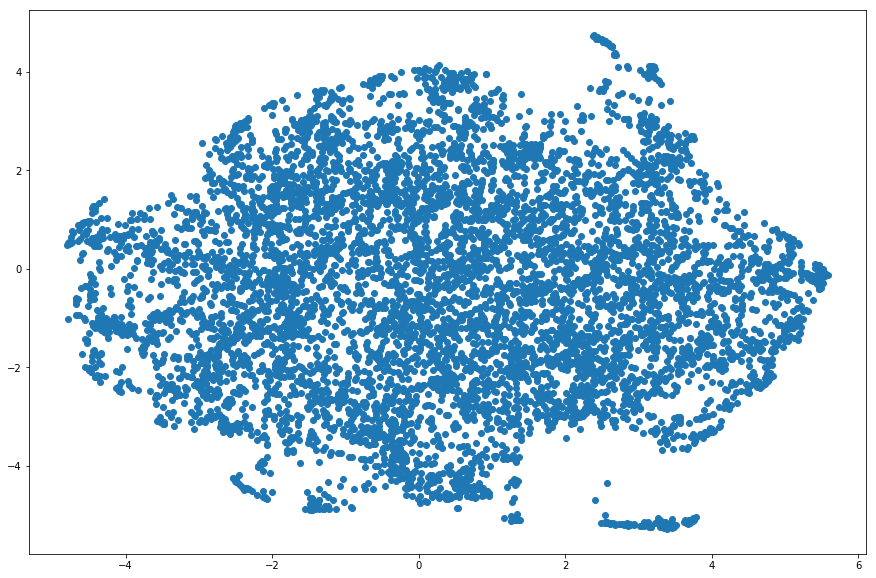

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.scatter(*embedding.T)

## tSNE

This is part of `sklearn`:

In [84]:
import numpy as np
from sklearn.manifold import TSNE

embedding_tsne = TSNE().fit_transform(X)
embedding_tsne.shape

(7105, 2)

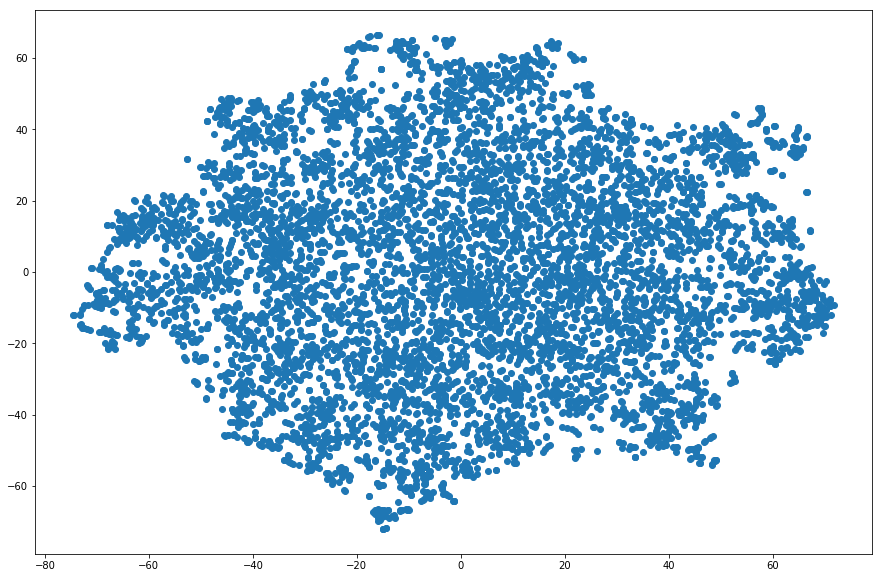

In [88]:
plt.figure(figsize=(15, 10))
plt.scatter(*embedding_tsne.T)